<a href="https://colab.research.google.com/github/tgwon/ai4ml/blob/main/project/baseline2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
light_df = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

In [54]:
child_area_df = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [55]:
parking_df = pd.read_csv('/content/drive/MyDrive/ai4ml/open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

In [56]:
train_org = pd.read_csv('/content/drive/MyDrive/ai4ml/open/train.csv')
test_org = pd.read_csv('/content/drive/MyDrive/ai4ml/open/test.csv')

display(train_org.head())
display(test_org.head())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


In [57]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

In [58]:
# train_df에서 test_df에 존재하지 않는 시군구 값 제거
train_df = train_df[train_df['시군구'].isin(test_df['시군구'])]

In [59]:
train_df['시간'] = train_df['시간'].apply(lambda x: 1 if 6 <= x <= 20 else 0)
train_df = pd.get_dummies(train_df, columns=['시간'])
train_df = train_df.rename(columns={'시간_0': '휴식시간대'})
train_df = train_df.rename(columns={'시간_1': '활동시간대'})

In [60]:
test_df['시간'] = test_df['시간'].apply(lambda x: 1 if 6 <= x <= 20 else 0)
test_df = pd.get_dummies(test_df, columns=['시간'])
test_df = test_df.rename(columns={'시간_0': '휴식시간대'})
test_df = test_df.rename(columns={'시간_1': '활동시간대'})

In [61]:
train_df['주말'] = train_df['요일'].apply(lambda x: 1 if x in ['토요일', '일요일'] else 0)
train_df = train_df.drop(columns=['요일'])
test_df['주말'] = test_df['요일'].apply(lambda x: 1 if x in ['토요일', '일요일'] else 0)
test_df = test_df.drop(columns=['요일'])

In [62]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

In [63]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [64]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

In [65]:
train_df.columns

Index(['ID', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',
       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',
       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',
       '월', '일', '휴식시간대', '활동시간대', '주말', '도시', '구', '동', '도로형태1', '도로형태2',
       '설치개수', 'cnt', '급지구분_1', '급지구분_2', '급지구분_3'],
      dtype='object')

In [66]:
test_df.columns

Index(['ID', '기상상태', '노면상태', '사고유형', '연', '월', '일', '휴식시간대', '활동시간대', '주말',
       '도시', '구', '동', '도로형태1', '도로형태2', '설치개수', 'cnt', '급지구분_1', '급지구분_2',
       '급지구분_3'],
      dtype='object')

In [67]:
test_x = test_df.drop(columns=['ID','도시','연','활동시간대']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [12]:
pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.3 MB/s eta 0:00:00


In [68]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['기상상태', '노면상태', '사고유형', '구', '동', '도로형태1', '도로형태2']

,기상상태,노면상태,사고유형,월,일,휴식시간대,주말,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.711899,4.711895,3.816903,1,1,1,0,4.541971,4.282449,4.670114,4.597902,391.0,2.0,11.0,0.0,0.0
1,4.779150,4.711895,3.816903,1,1,1,0,4.618441,4.738938,4.670114,4.597902,932.0,NaN,0.0,1.0,3.0
2,4.711899,4.711895,3.816903,1,1,1,0,4.727300,4.842715,4.670114,4.597902,473.0,5.0,NaN,NaN,NaN
3,4.711899,4.711895,4.943659,1,1,1,0,4.686974,4.208920,4.670114,4.597902,534.0,11.0,0.0,9.0,5.0
4,4.711899,4.711895,4.943659,1,1,1,0,4.883878,4.549091,4.670114,4.597902,2057.0,NaN,0.0,1.0,0.0


,기상상태,노면상태,사고유형,월,일,휴식시간대,주말,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.711899,4.711895,3.816903,1,1,1,1,4.727300,4.881657,4.882473,5.006145,700.0,5.0,NaN,NaN,NaN
1,4.711899,4.711895,3.816903,1,1,1,1,4.727300,4.563008,4.670114,4.597902,NaN,10.0,0.0,0.0,2.0
2,4.711899,4.711895,4.943659,1,1,1,1,4.727300,4.945578,4.882473,5.006145,NaN,1.0,NaN,NaN,NaN
3,4.711899,4.711895,4.943659,1,1,1,1,4.727300,4.438172,4.670114,4.597902,NaN,7.0,0.0,2.0,1.0
4,4.711899,4.711895,4.943659,1,1,0,1,4.618441,4.738938,4.882473,5.006145,932.0,NaN,0.0,1.0,3.0


In [69]:
train_x.fillna(0, inplace=True)
test_x.fillna(0, inplace=True)

In [70]:
import tensorflow as tf

def rmsle(y_true, y_pred):
    y_true = tf.maximum(tf.cast(y_true, tf.float32), 0)
    y_pred = tf.maximum(tf.cast(y_pred, tf.float32), 0)

    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))

    return tf.sqrt(tf.reduce_mean(squared_error))
def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

In [71]:
# 사용자 정의 손실 함수를 문자열로 변환
loss_fn_str = tf.keras.losses.serialize(rmsle)

In [72]:
#from tensorflow.keras.callbacks import ModelCheckpoint

# 모델 저장 콜백 정의
checkpoint_path = "best_model.h5"

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=2, mode='min',restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
]

In [73]:
def create_model():

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(input_layer)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    #x = tf.keras.layers.BatchNormalization(epsilon=0.00001)(x)
    output_layer = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                  loss=rmsle,
                  metrics=[rmsle]
                  )

    return model

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_split=0.1)

Epoch 1/100
1106/1114 [============================>.] - ETA: 0s - loss: 0.5223 - rmsle: 0.5223
Epoch 1: val_loss improved from inf to 0.43056, saving model to best_model.h5
1114/1114 [==============================] - 8s 6ms/step - loss: 0.5219 - rmsle: 0.5220 - val_loss: 0.4306 - val_rmsle: 0.4305 - lr: 0.0010
Epoch 2/100
1102/1114 [============================>.] - ETA: 0s - loss: 0.4598 - rmsle: 0.4598
Epoch 2: val_loss improved from 0.43056 to 0.42780, saving model to best_model.h5
1114/1114 [==============================] - 5s 4ms/step - loss: 0.4598 - rmsle: 0.4596 - val_loss: 0.4278 - val_rmsle: 0.4277 - lr: 0.0010
Epoch 3/100
1103/1114 [============================>.] - ETA: 0s - loss: 0.4545 - rmsle: 0.4545
Epoch 3: val_loss improved from 0.42780 to 0.42454, saving model to best_model.h5
1114/1114 [==============================] - 5s 4ms/step - loss: 0.4545 - rmsle: 0.4546 - val_loss: 0.4245 - val_rmsle: 0.4245 - lr: 0.0010
Epoch 4/100
1104/1114 [===========================

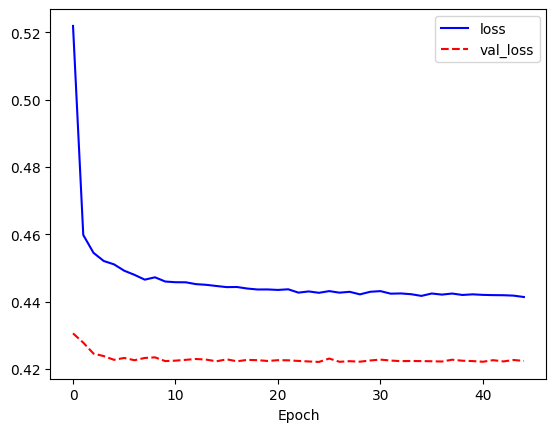

In [74]:
# train loss, val loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [75]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# 저장된 모델 불러오기
loaded_model = load_model("best_model.h5", custom_objects={'rmsle': rmsle})

In [77]:
sample_submission = pd.read_csv('/content/drive/MyDrive/ai4ml/open/sample_submission.csv')

sample_submission["ECLO"] = loaded_model.predict(test_x.astype('float32'))

sample_submission.to_csv("submit5.csv", index=False)

343/343 [==============================] - 2s 6ms/step


In [78]:
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,3.916062
1,ACCIDENT_39610,3.537889
2,ACCIDENT_39611,5.151416
3,ACCIDENT_39612,4.466825
4,ACCIDENT_39613,4.594382


In [79]:
test_df.head()

,ID,기상상태,노면상태,사고유형,연,월,일,휴식시간대,활동시간대,주말,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,ACCIDENT_39609,맑음,건조,차대사람,2022,1,1,1,0,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN
1,ACCIDENT_39610,맑음,건조,차대사람,2022,1,1,1,0,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0
2,ACCIDENT_39611,맑음,건조,차대차,2022,1,1,1,0,1,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN
3,ACCIDENT_39612,맑음,건조,차대차,2022,1,1,1,0,1,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0
4,ACCIDENT_39613,맑음,건조,차대차,2022,1,1,0,1,1,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0


In [80]:
test_df['ECLO'] = loaded_model.predict(test_x.astype('float32'))

343/343 [==============================] - 1s 2ms/step


In [81]:
test_df.head()

,ID,기상상태,노면상태,사고유형,연,월,일,휴식시간대,활동시간대,주말,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,ECLO
0,ACCIDENT_39609,맑음,건조,차대사람,2022,1,1,1,0,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN,3.916062
1,ACCIDENT_39610,맑음,건조,차대사람,2022,1,1,1,0,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0,3.537889
2,ACCIDENT_39611,맑음,건조,차대차,2022,1,1,1,0,1,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,5.151416
3,ACCIDENT_39612,맑음,건조,차대차,2022,1,1,1,0,1,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0,4.466825
4,ACCIDENT_39613,맑음,건조,차대차,2022,1,1,0,1,1,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,4.594382


In [82]:
test_df[test_df.동 == '노곡동']

,ID,기상상태,노면상태,사고유형,연,월,일,휴식시간대,활동시간대,주말,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,ECLO
988,ACCIDENT_40597,맑음,건조,차대차,2022,2,6,0,1,1,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,6.091120
1554,ACCIDENT_41163,맑음,건조,차대차,2022,2,28,0,1,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.764426
2328,ACCIDENT_41937,맑음,건조,차대차,2022,3,29,0,1,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.783408
2904,ACCIDENT_42513,맑음,건조,차량단독,2022,4,17,0,1,1,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.191380
2905,ACCIDENT_42514,맑음,건조,차대차,2022,4,17,0,1,1,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,6.157517
2969,ACCIDENT_42578,맑음,건조,차대차,2022,4,19,0,1,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.769260
3710,ACCIDENT_43319,맑음,건조,차대차,2022,5,12,0,1,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.773962
4707,ACCIDENT_44316,맑음,건조,차대차,2022,6,12,1,0,1,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,6.673030
5084,ACCIDENT_44693,맑음,건조,차대차,2022,6,24,1,0,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,6.236396
5966,ACCIDENT_45575,맑음,건조,차대차,2022,7,21,0,1,0,대구광역시,북구,노곡동,단일로,기타,140.0,NaN,0.0,0.0,3.0,5.821430


In [84]:
test_df[test_df.동 == '대안동']

,ID,기상상태,노면상태,사고유형,연,월,일,휴식시간대,활동시간대,주말,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,ECLO
3566,ACCIDENT_43175,맑음,건조,차대차,2022,5,8,1,0,1,대구광역시,중구,대안동,교차로,교차로안,47.0,NaN,3.0,0.0,0.0,5.479242


In [85]:
# 대안동의 평균 ECLO 계산
mean_eclo_daean = train_df[train_df['동'] == '대안동']['ECLO'].mean()
mean_eclo_daean

9.333333333333334

In [86]:
# 대안동의 ECLO가 0인 경우 대치
test_df.loc[test_df['동'] == '대안동', 'ECLO'] = mean_eclo_daean

In [87]:
sample_submission["ECLO"] = test_df['ECLO']

sample_submission.to_csv("submit6.csv", index=False)

# 후처리

In [28]:
# 구, 동별 ECLO의 평균 계산
mean_eclo_by_region = test_df.groupby(['구', '동'])['ECLO'].mean().reset_index()

In [29]:
# 원본 ECLO와 구, 동별 평균을 합침
merged_df = pd.merge(test_df, mean_eclo_by_region, on=['구', '동'], how='left', suffixes=('', '_mean'))
merged_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,ECLO,ECLO_mean
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN,4.115527,4.187116
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0,3.876325,3.890129
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,5.113765,4.139020
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0,4.510483,3.833356
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,4.825438,4.028691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,남구,대명동,단일로,터널,5377.0,26.0,20.0,1.0,0.0,5.339770,3.802781
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,수성구,시지동,단일로,기타,NaN,5.0,NaN,NaN,NaN,4.277039,4.234334
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,연호동,단일로,기타,NaN,NaN,NaN,NaN,NaN,4.741353,4.655102
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,범물동,교차로,교차로부근,NaN,7.0,NaN,NaN,NaN,4.595987,4.222440


In [ ]:
# ECLO가 지역별 평균보다 작으면 평균으로 대체
merged_df['ECLO'] = merged_df.apply(lambda row: row['ECLO_mean'] if row['ECLO'] < row['ECLO_mean'] else row['ECLO'], axis=1)

# 필요 없는 열 삭제
merged_df = merged_df.drop(columns=['ECLO_mean'])

In [31]:
merged_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3,ECLO
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,700.0,5.0,NaN,NaN,NaN,4.187116
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,NaN,10.0,0.0,0.0,2.0,3.890129
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,NaN,1.0,NaN,NaN,NaN,5.113765
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,NaN,7.0,0.0,2.0,1.0,4.510483
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,932.0,NaN,0.0,1.0,3.0,4.825438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,남구,대명동,단일로,터널,5377.0,26.0,20.0,1.0,0.0,5.339770
10959,ACCIDENT_50568,토요일,맑음,건조,차대차,2022,12,31,18,대구광역시,수성구,시지동,단일로,기타,NaN,5.0,NaN,NaN,NaN,4.277039
10960,ACCIDENT_50569,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,연호동,단일로,기타,NaN,NaN,NaN,NaN,NaN,4.741353
10961,ACCIDENT_50570,토요일,맑음,건조,차대차,2022,12,31,20,대구광역시,수성구,범물동,교차로,교차로부근,NaN,7.0,NaN,NaN,NaN,4.595987


In [32]:
sample_submission["ECLO"] = merged_df['ECLO']

sample_submission.to_csv("submit4.csv", index=False)